# Generate figures for paper

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

Figures are generated from combined data from three datasets from each of the
following conditions:

* As deformed (0s)
* Annealed to 175 $^{\circ}$C (175c)
* Annealed to 300 $^{\circ}$C (300c)
* Annealed to 325 $^{\circ}$C (325c)

Import required libraries and print their versions

In [1]:
# Switch to interactive Matplotlib backend (e.g. qt5) for control point determination
%matplotlib inline

from datetime import date
import importlib_metadata
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import host_subplot, make_axes_locatable
import numpy as np
import pandas as pd
import pyexcel_ods3 as pxl

from mapregions import MapRegions


print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in ["mapregions", "matplotlib", "numpy", "pandas", "pyexcel_ods3"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-09-09

Software versions
-----------------
mapregions : 0.1.dev1
matplotlib : 3.5.2
numpy : 1.22.4
pandas : 1.4.3
pyexcel_ods3 : 0.6.1


Descriptions of texture components

In [15]:
comp_names = ["Other", "Br", "Cu", "S", "Cube", "CubeND", "P", "Goss"]
comp_names_low = list(map(str.lower, comp_names))
comp_markers = ["o", "d", "^", "*", "s", "s", ">", "o"]
comp_colors = [(1, 1, 1), (1, 0, 1), (0, 0, 1), (0, 0.5, 0), (1, 0, 0), (1, 0.55, 0), (0, 1, 1), (1, 1, 0)]
n_ideal = len(comp_names)

comp_name_def = "Br, Cu, S"
comp_color_def = (1, 0, 1)
comp_marker_def = "d"

In [2]:
# Directories for input and output
dir_data = "/home/hakon/phd/data/p"
dir_article = "/home/hakon/phd/artikler_abstract/202204_p_texture_almn_alloy/latex/fig"

# Matplotlib configuration and keyword arguments
plt.rcParams.update({"font.size": 11, "figure.dpi": 300})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, transparent=True)
scatter_kw = dict(s=70, linewidth=2, facecolor="none", clip_on=False)
title_kw = dict(ha="left", va="bottom", fontweight="bold")

# Nominal step sizes nm/px
step_size = dict(ebsd=100, bse=1 / 39e-3)

# Particle size thresholds
dispersoid_threshold = 0.24  # um
constituent_threshold = 0.8  # um

# Variables for plotting
titles = ["as def.", r"175 $^{\circ}$C", r"300 $^{\circ}$C", r"325 $^{\circ}$C"]
identifier = ["0s", "175c", "300c", "325c"]

## Recrystallization kinetics and overall texture

### Electrical conductivity, hardness and macrotexture volume fractions

Read data from LibreOffice Calc

In [3]:
def get_data_frame(data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", np.VisibleDeprecationWarning)
        data_array = np.full(shape=np.shape(data) + np.shape(data[0]), fill_value=np.nan, dtype=object)
    columns = []
    skip = 0
    for i, l in enumerate(data):
        if len(l) == 0:
            skip += 1
        else:
            for j, value in enumerate(l):
                try:
                    if value != "":
                        data_array[i, j] = value
                except IndexError:
                    pass
    return pd.DataFrame(data=data_array[1:-skip], columns=data_array[0])


# EC
data_file = os.path.join(dir_data, "ec/ec.ods")
data = pxl.get_data(data_file)
ec = get_data_frame(data["all"][:-2])[:-1]

# HV
data_file = os.path.join(dir_data, "hv/hv.ods")
data = pxl.get_data(data_file)
hv = get_data_frame(data["ark1"][:-2])[:-1]

# Macrotexture
data_file = os.path.join(dir_data, "macrotexture/macrotexture_3xxx.ods")
data = pxl.get_data(data_file)
texture = get_data_frame(data["Ark2"])[:-1]

Plot (a) electrical conductivity and hardness and (b) texture volume fractions

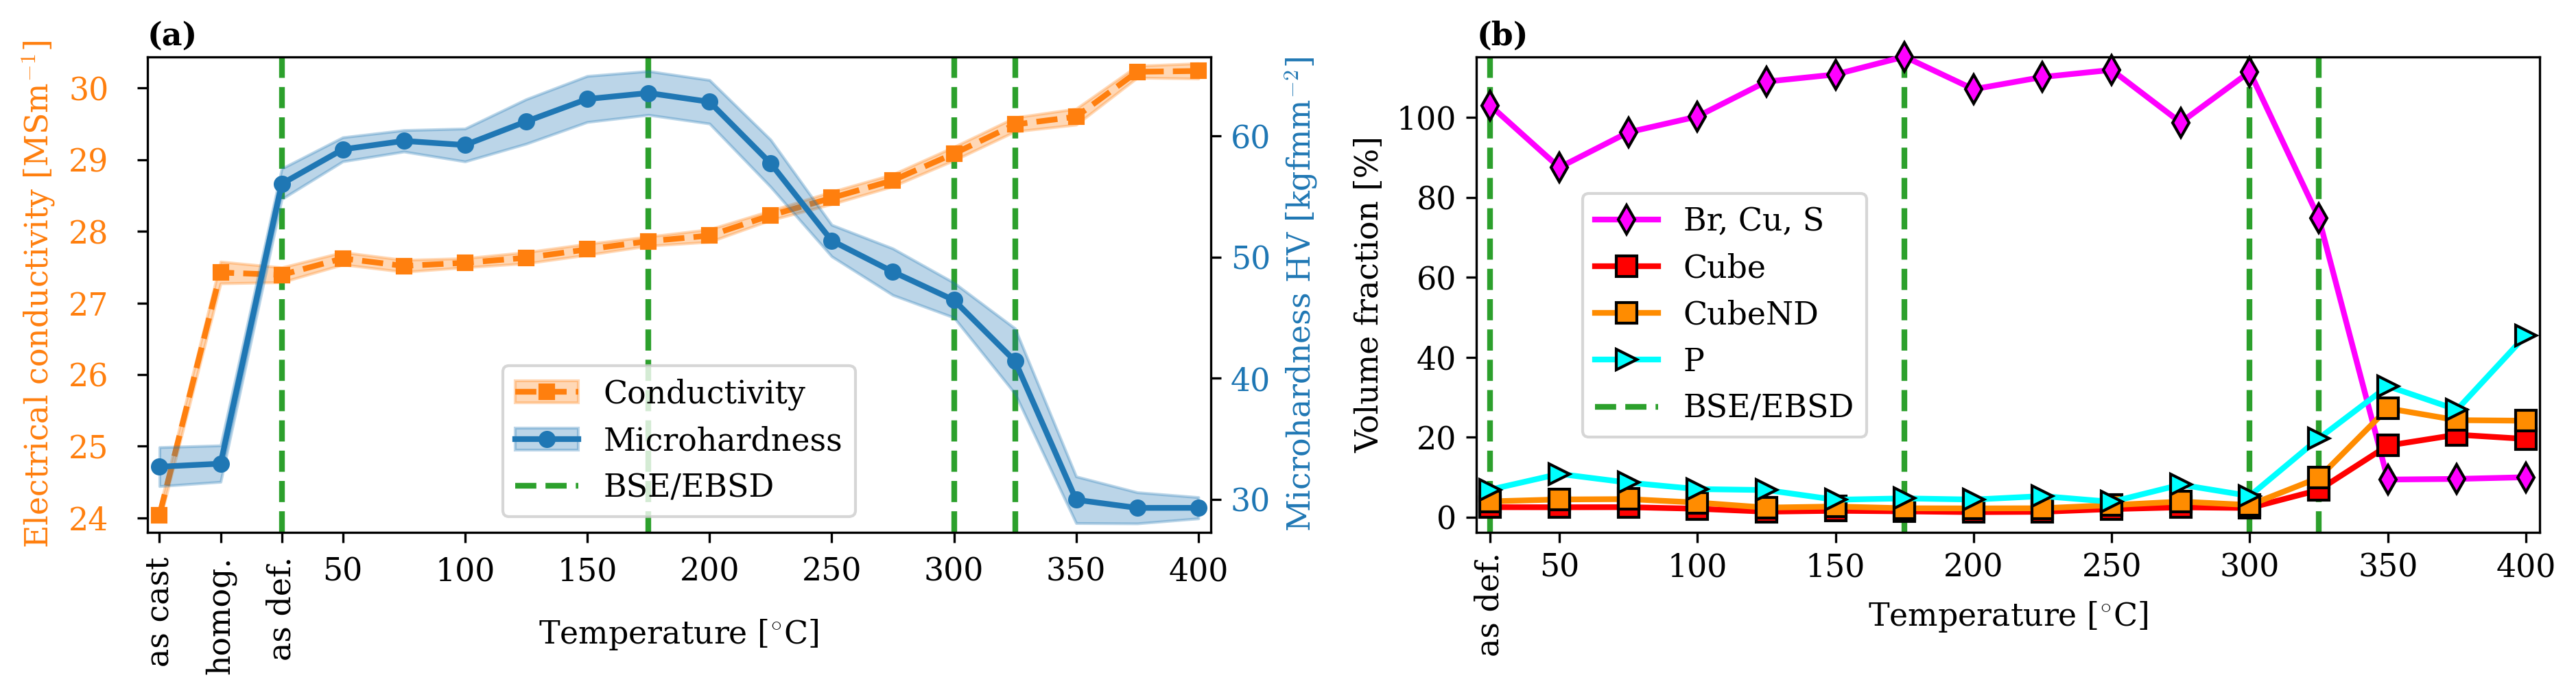

In [4]:
line_kw = dict(lw=2)
bse_ebsd_kw = dict(color="C2", linestyle="--")
bse_ebsd_kw.update(line_kw)

# (a) EC and HV
# -------------

# Tick properties
xtick_loc0 = np.array([0, 1, 2, 3, 5, 7, 9, 11, 13, 15, 17])
xtick_numbered_n = len(xtick_loc0) - 5
xtick_labels0 = [
    "as cast", "homog.", "as def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90, 90, 90] + ["horizontal"] * xtick_numbered_n + [15]
xtick_alignments = ["center",] * 3 + ["center"] * xtick_numbered_n

# Uncertainty
hv_std_upper = (hv.hv + 2*hv.hv_std).astype(float)
hv_std_lower = (hv.hv - 2*hv.hv_std).astype(float)
ec_std_upper = (ec.ec + 2*ec.ec_std).astype(float)
ec_std_lower = (ec.ec - 2*ec.ec_std).astype(float)

# Setup figure
fig, (ax0, ax2) = plt.subplots(ncols=2, figsize=(15, 3))

# Plot conductivity
ec_color = "C1"
p1 = ax0.plot(ec.index, ec.ec, "--s", color=ec_color, clip_on=False, zorder=3, **line_kw)
p2 = ax0.fill_between(x=ec.index, y1=ec_std_upper, y2=ec_std_lower, color=ec_color, alpha=0.3)
ax0.set_ylabel("Electrical conductivity [MSm$^{-1}$]", color=ec_color)
ax0.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)

# Plot hardness
hv_color = "C0"
ax1 = ax0.twinx()
p3 = ax1.plot(hv.index, hv.hv, "-o", color=hv_color, clip_on=False, **line_kw)
p4 = ax1.fill_between(x=hv.index, y1=hv_std_upper, y2=hv_std_lower, color=hv_color, alpha=0.3)
p5 = ax1.plot(np.nan, "--o", color=hv_color)
ax1.set_ylabel("Microhardness HV [kgfmm$^{-2}$]", color=hv_color)
ax1.set_frame_on(False)

# Tick parameters
hv_min = hv.hv.min() - 2
hv_max = hv.hv.max() + 3
ec_min = 24 - 0.2
ec_max = ec.ec.max() + 0.2
ax0.set_ylim([ec_min, ec_max])
ax1.set_xlim([hv.index.start - 0.2, hv.index.stop - 0.8])
ax1.set_ylim([hv_min, hv_max])
ax0.set_xticks(xtick_loc0)
ax0.set_xticklabels(xtick_labels0);
ax0.tick_params(axis="x", pad=5)
ax0.tick_params(axis="y", labelcolor=ec_color, pad=10)
ax1.tick_params(axis="y", labelcolor=hv_color)
for label, tick, rot, align in zip(
    ax0.get_xmajorticklabels(),
    ax0.get_xaxis().get_major_ticks(),
    xtick_rotations,
    xtick_alignments,
):
    label.set_rotation(rot)
    label.set_horizontalalignment(align)

# Conditions studied by BSE/EBSD
for condition in [2, 8, 13, 14]:
    p5 = ax0.axvline(condition, **bse_ebsd_kw)

# Legend
ax0.legend(
    [(p1[0], p2), (p3[0], p4), p5],
    ["Conductivity", "Microhardness", "BSE/EBSD"],
    frameon=True,
    loc="lower center",
);

# Subfigure label
ax0.text(0, 1.01, "(a)", transform=ax0.transAxes, **title_kw);


# (b) Texture volume fractions
# ----------------------------
# Tick properties
xtick_loc1 = np.array([0, 1, 3, 5, 7, 9, 11, 13, 15])
xtick_numbered_n = (len(xtick_loc1) - 2)
xtick_labels1 = [
    "as def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90] + ["horizontal"] * (xtick_numbered_n + 1)

# Texture component descriptions
names = [comp_name_def, "Cube", "CubeND", "P"]
markers = [comp_marker_def, "s", "s", ">"]
colors = [comp_color_def, (1, 0, 0), (1, 0.55, 0), (0, 1, 1)]
marker_kwds = dict(markersize=7, markeredgecolor="k")

for data, name, marker, color in zip(
    [texture.deform, texture.cube, texture.cubend, texture.p],
    names,
    markers,
    colors
):
    ax2.plot(
        texture.index,
        data,
        f"{marker}-",
        color=color,
        label=name,
        zorder=3,
        clip_on=False,
        **marker_kwds,
        **line_kw,
    )

# Y limits
m_values = [texture.p.values, texture.cube.values, texture.cubend.values, texture.deform.values]
y_lim = [np.nanmin(m_values) - 5, np.nanmax(m_values)]
ax2.set_ylim(y_lim)

ax2.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)
ax2.set_ylabel("Volume fraction [%]")

# Tick parameters
ax2.set_xlim([texture.index.start - 0.2, texture.index.stop - 0.8])
ax2.set_xticks(xtick_loc1)
ax2.set_xticklabels(xtick_labels1)
for label, rot in zip(ax2.get_xmajorticklabels(), xtick_rotations):
    label.set_rotation(rot)

# Conditions studied by BSE/EBSD
conditions = [0, 6, 11, 12]
for condition in conditions:
    if condition == conditions[-1]:
        label = "BSE/EBSD"
    else:
        label=None
    ax2.axvline(condition, label=label, **bse_ebsd_kw)

# Legend
ax2.legend(loc=(0.1, 0.2))

# Subfigure label
ax2.text(0, 1.01, "(b)", transform=ax2.transAxes, **title_kw);

# Save figure
fig.subplots_adjust(wspace=0.25)
#fig.savefig(os.path.join(dir_article, "rx_kinetics/ec_hv_volume_fractions.pdf"), **savefig_kw)

Plot change in HV and EC

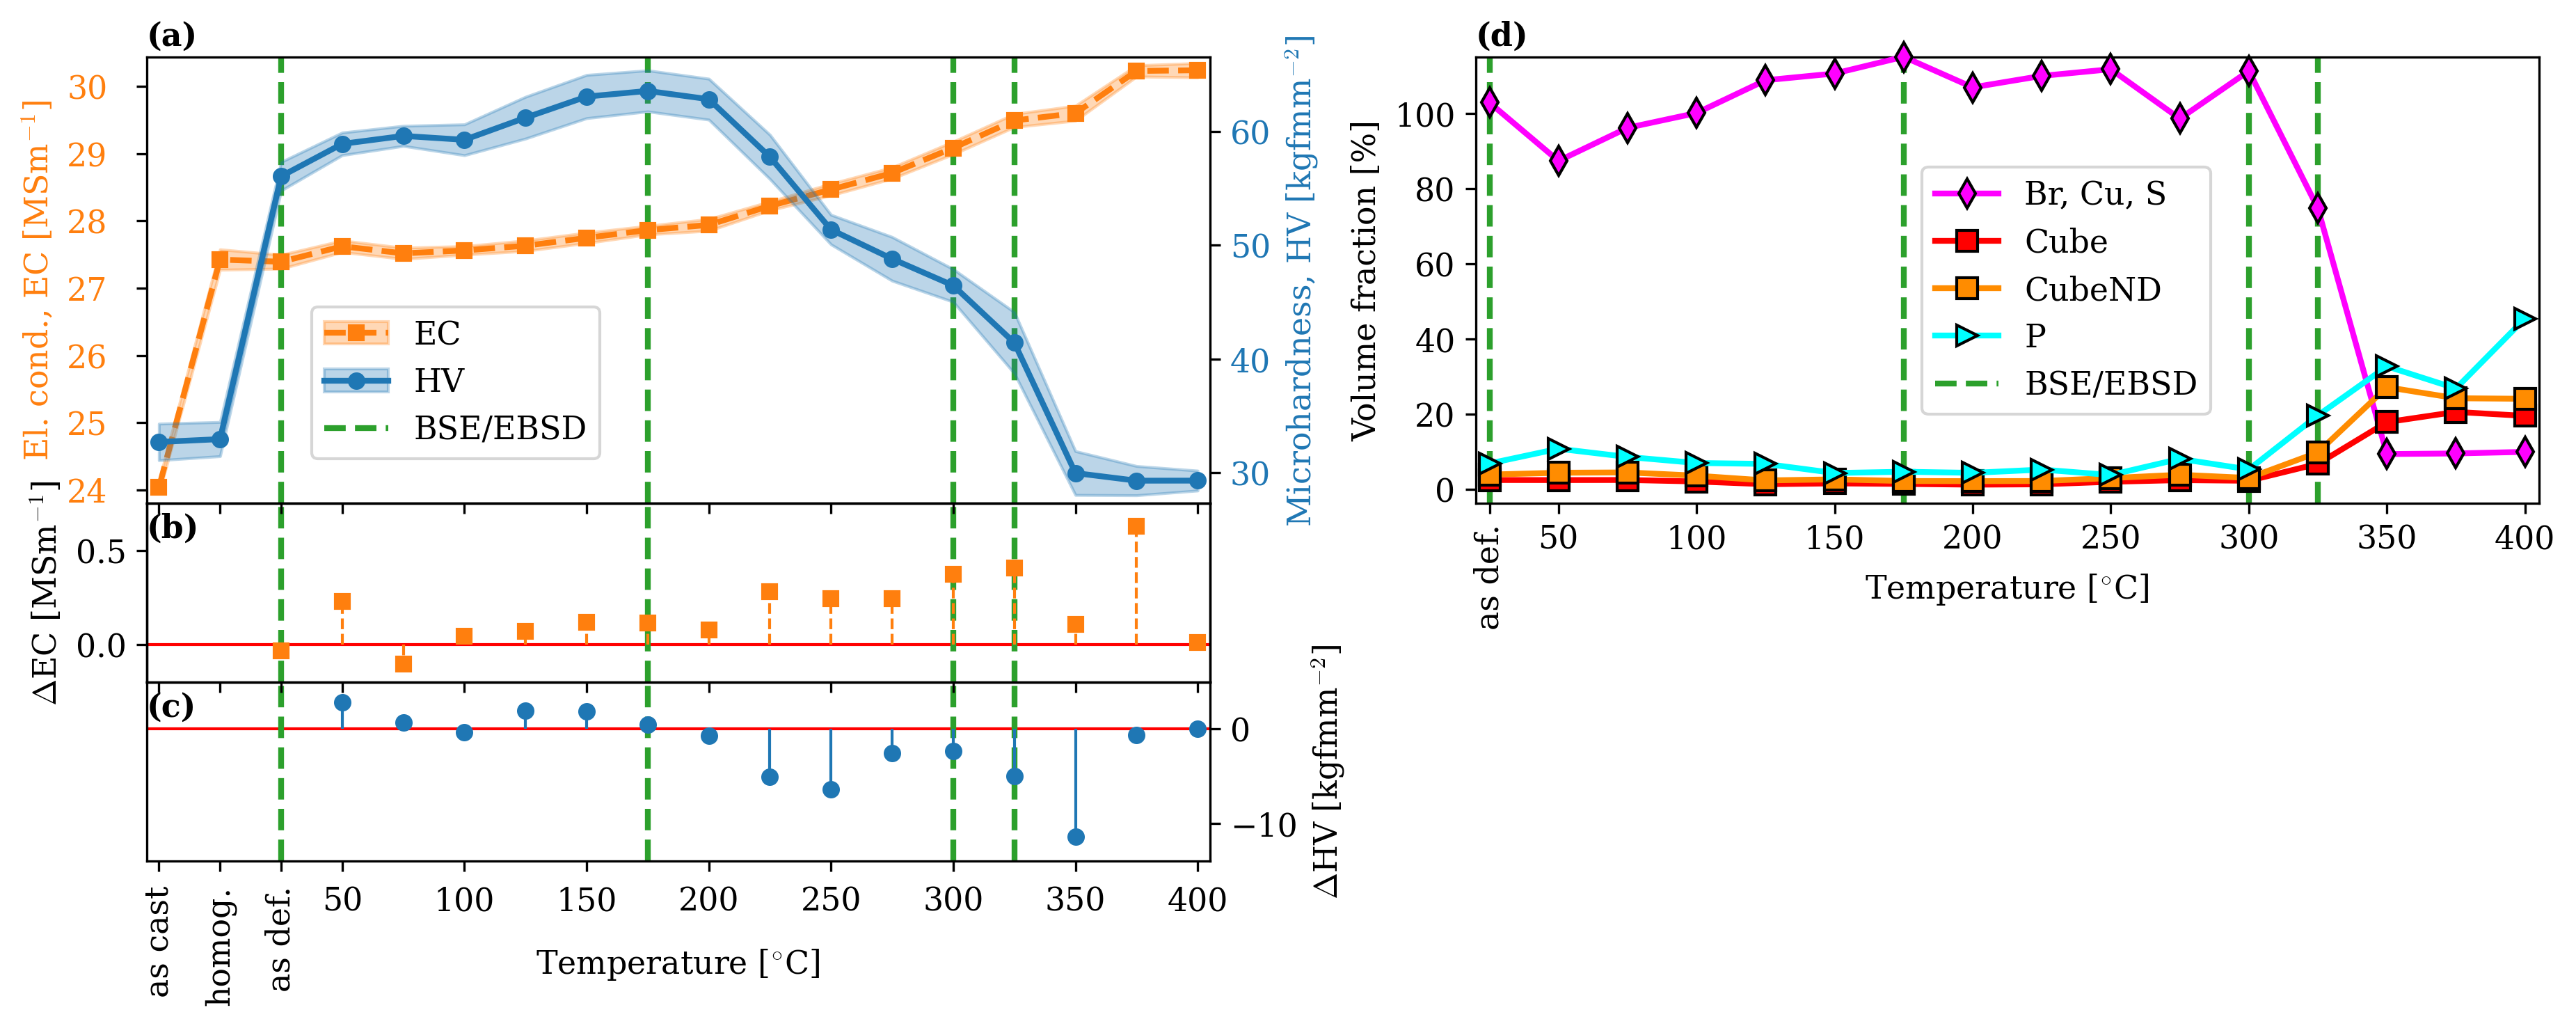

In [5]:
line_kw = dict(lw=2)
bse_ebsd_kw = dict(color="C2", linestyle="--", zorder=0)
bse_ebsd_kw.update(line_kw)

# EC/HV diff.
ec_diff = np.insert(np.diff(ec.ec).astype(float), 0, np.nan)
hv_diff = np.insert(np.diff(hv.hv).astype(float), 0, np.nan)
ec_diff[1] = np.nan
hv_diff[[1, 2]] = np.nan

# Create figure with a grid
fig = plt.figure(figsize=(23, 5))
gs = fig.add_gridspec(3, 3, height_ratios=[2.5, 1, 1])

# (a) EC and HV
# -------------
ax2 = fig.add_subplot(gs[2, 0])
ax0_ec = fig.add_subplot(gs[0, 0], sharex=ax2)
ax1 = fig.add_subplot(gs[1, 0], sharex=ax2)

# Tick properties
xtick_loc0 = np.array([0, 1, 2, 3, 5, 7, 9, 11, 13, 15, 17])
xtick_numbered_n = len(xtick_loc0) - 5
xtick_labels0 = [
    "as cast", "homog.", "as def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90, 90, 90] + ["horizontal"] * xtick_numbered_n + [15]
xtick_alignments = ["center",] * 3 + ["center"] * xtick_numbered_n

# Uncertainty
hv_std_upper = (hv.hv + 2*hv.hv_std).astype(float)
hv_std_lower = (hv.hv - 2*hv.hv_std).astype(float)
ec_std_upper = (ec.ec + 2*ec.ec_std).astype(float)
ec_std_lower = (ec.ec - 2*ec.ec_std).astype(float)

# Plot EC
ec_color = "C1"
p1 = ax0_ec.plot(ec.index, ec.ec, "--s", color=ec_color, clip_on=False, zorder=3, **line_kw)
p2 = ax0_ec.fill_between(x=ec.index, y1=ec_std_upper, y2=ec_std_lower, color=ec_color, alpha=0.3)
ax0_ec.set_ylabel("El. cond., EC [MSm$^{-1}$]", color=ec_color)

# Plot HV
hv_color = "C0"
ax0_hv = ax0_ec.twinx()
p3 = ax0_hv.plot(hv.index, hv.hv, "-o", color=hv_color, clip_on=False, **line_kw)
p4 = ax0_hv.fill_between(x=hv.index, y1=hv_std_upper, y2=hv_std_lower, color=hv_color, alpha=0.3)
p5 = ax0_hv.plot(np.nan, "--o", color=hv_color)
ax0_hv.set_ylabel("Microhardness, HV [kgfmm$^{-2}$]", color=hv_color)
ax0_hv.set_frame_on(False)

# Plot EC difference
ax1.stem(ec.index, ec_diff, bottom=0, linefmt="--" + ec_color, markerfmt=ec_color + "s", basefmt="none")
ax1.plot([-10, 20], [0, 0], zorder=0, color="r")
ax1.set_ylim(-0.2, 0.75)
ax1.set_ylabel("$\Delta$EC [MSm$^{-1}$]")

# Plot HV difference
ax2.stem(hv.index, hv_diff, bottom=0, linefmt="-" + hv_color, markerfmt=hv_color + "o", basefmt="none")
ax2.plot([-10, 20], [0, 0], zorder=0, color="r")
ax2.set_ylim(-14, 5)
ax2.set_ylabel("$\Delta$HV [kgfmm$^{-2}$]")

# Axis limits
hv_min = hv.hv.min() - 2
hv_max = hv.hv.max() + 3
ec_min = 24 - 0.2
ec_max = ec.ec.max() + 0.2
ax0_ec.set_ylim([ec_min, ec_max])
ax0_hv.set_ylim([hv_min, hv_max])
ax2.set_xlim([hv.index.start - 0.2, hv.index.stop - 0.8])

# Tick parameters
ax0_ec.tick_params(axis="x", labelbottom=False)
ax1.tick_params(axis="x", labelbottom=False)
ax2.set_xticks(xtick_loc0)
ax2.set_xticklabels(xtick_labels0)
ax2.tick_params(axis="x", pad=5)
ax0_ec.tick_params(axis="y", labelcolor=ec_color, pad=10)
ax0_hv.tick_params(axis="y", labelcolor=hv_color)
# With no vertical spacing between subplots, ax0's x ticks aren't visible, so
# we add extra ticks to the top of ax1
ax11 = ax1.twiny()
ax11.set_xlim(ax1.get_xlim())
ax11.set_xticks(ax1.get_xticks())
ax11.set_xticklabels([])
ax11.xaxis.tick_top()
ax11.tick_params(axis="x", which="both", direction="in")
# Align x tick labels
for label, tick, rot, align in zip(
    ax2.get_xmajorticklabels(),
    ax2.get_xaxis().get_major_ticks(),
    xtick_rotations,
    xtick_alignments,
):
    label.set_rotation(rot)
    label.set_horizontalalignment(align)
# Move HV difference y ticks to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# Conditions studied by BSE/EBSD
for condition in [2, 8, 13, 14]:
    p5 = ax0_ec.axvline(condition, **bse_ebsd_kw)
    ax1.axvline(condition, **bse_ebsd_kw)
    ax2.axvline(condition, **bse_ebsd_kw)

# Subfigure labels
ax0_ec.text(0, 1.01, "(a)", transform=ax0_ec.transAxes, **title_kw)
ax1.text(0, 0.95, "(b)", transform=ax1.transAxes, ha="left", va="top", fontweight="bold")
ax2.text(0, 0.95, "(c)", transform=ax2.transAxes, ha="left", va="top", fontweight="bold")

# EC/HV x axis labels
ax2.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)
ax2.set_xticks(xtick_loc0)
ax2.set_xticklabels(xtick_labels0);

# Legend
ax0_ec.legend(
    [(p1[0], p2), (p3[0], p4), p5],
    ["EC", "HV", "BSE/EBSD"],
    loc=(0.155, 0.1),
)

# (b) Texture volume fractions
# ----------------------------
ax3 = fig.add_subplot(gs[0, 1])

# Tick properties
xtick_loc1 = np.array([0, 1, 3, 5, 7, 9, 11, 13, 15])
xtick_numbered_n = (len(xtick_loc1) - 2)
xtick_labels1 = [
    "as def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90] + ["horizontal"] * (xtick_numbered_n + 1)

# Texture component descriptions
names = [comp_name_def, "Cube", "CubeND", "P"]
markers = [comp_marker_def, "s", "s", ">"]
colors = [comp_color_def, (1, 0, 0), (1, 0.55, 0), (0, 1, 1)]
marker_kwds = dict(markersize=7, markeredgecolor="k")

for data, name, marker, color in zip(
    [texture.deform, texture.cube, texture.cubend, texture.p],
    names,
    markers,
    colors
):
    ax3.plot(
        texture.index,
        data,
        f"{marker}-",
        color=color,
        label=name,
        zorder=3,
        clip_on=False,
        **marker_kwds,
        **line_kw,
    )

# Y limits
m_values = [texture.p.values, texture.cube.values, texture.cubend.values, texture.deform.values]
y_lim = [np.nanmin(m_values) - 5, np.nanmax(m_values)]
ax3.set_ylim(y_lim)

ax3.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)
ax3.set_ylabel("Volume fraction [%]")

# Tick parameters
ax3.set_xlim([texture.index.start - 0.2, texture.index.stop - 0.8])
ax3.set_xticks(xtick_loc1)
ax3.set_xticklabels(xtick_labels1)
for label, rot in zip(ax3.get_xmajorticklabels(), xtick_rotations):
    label.set_rotation(rot)

# Conditions studied by BSE/EBSD
conditions = [0, 6, 11, 12]
for condition in conditions:
    if condition == conditions[-1]:
        label = "BSE/EBSD"
    else:
        label=None
    ax3.axvline(condition, label=label, **bse_ebsd_kw)

# Legend
ax3.legend(loc=(0.42, 0.2))

# Subfigure label
ax3.text(0, 1.01, "(d)", transform=ax3.transAxes, **title_kw)

# Save figure
fig.subplots_adjust(wspace=0.25, hspace=0)
fig.savefig(os.path.join(dir_article, "rx_kinetics/ec_hv_volume_fractions.pdf"), **savefig_kw)

### Texture index $J$ and ODF maximum $f(g)_{max}$

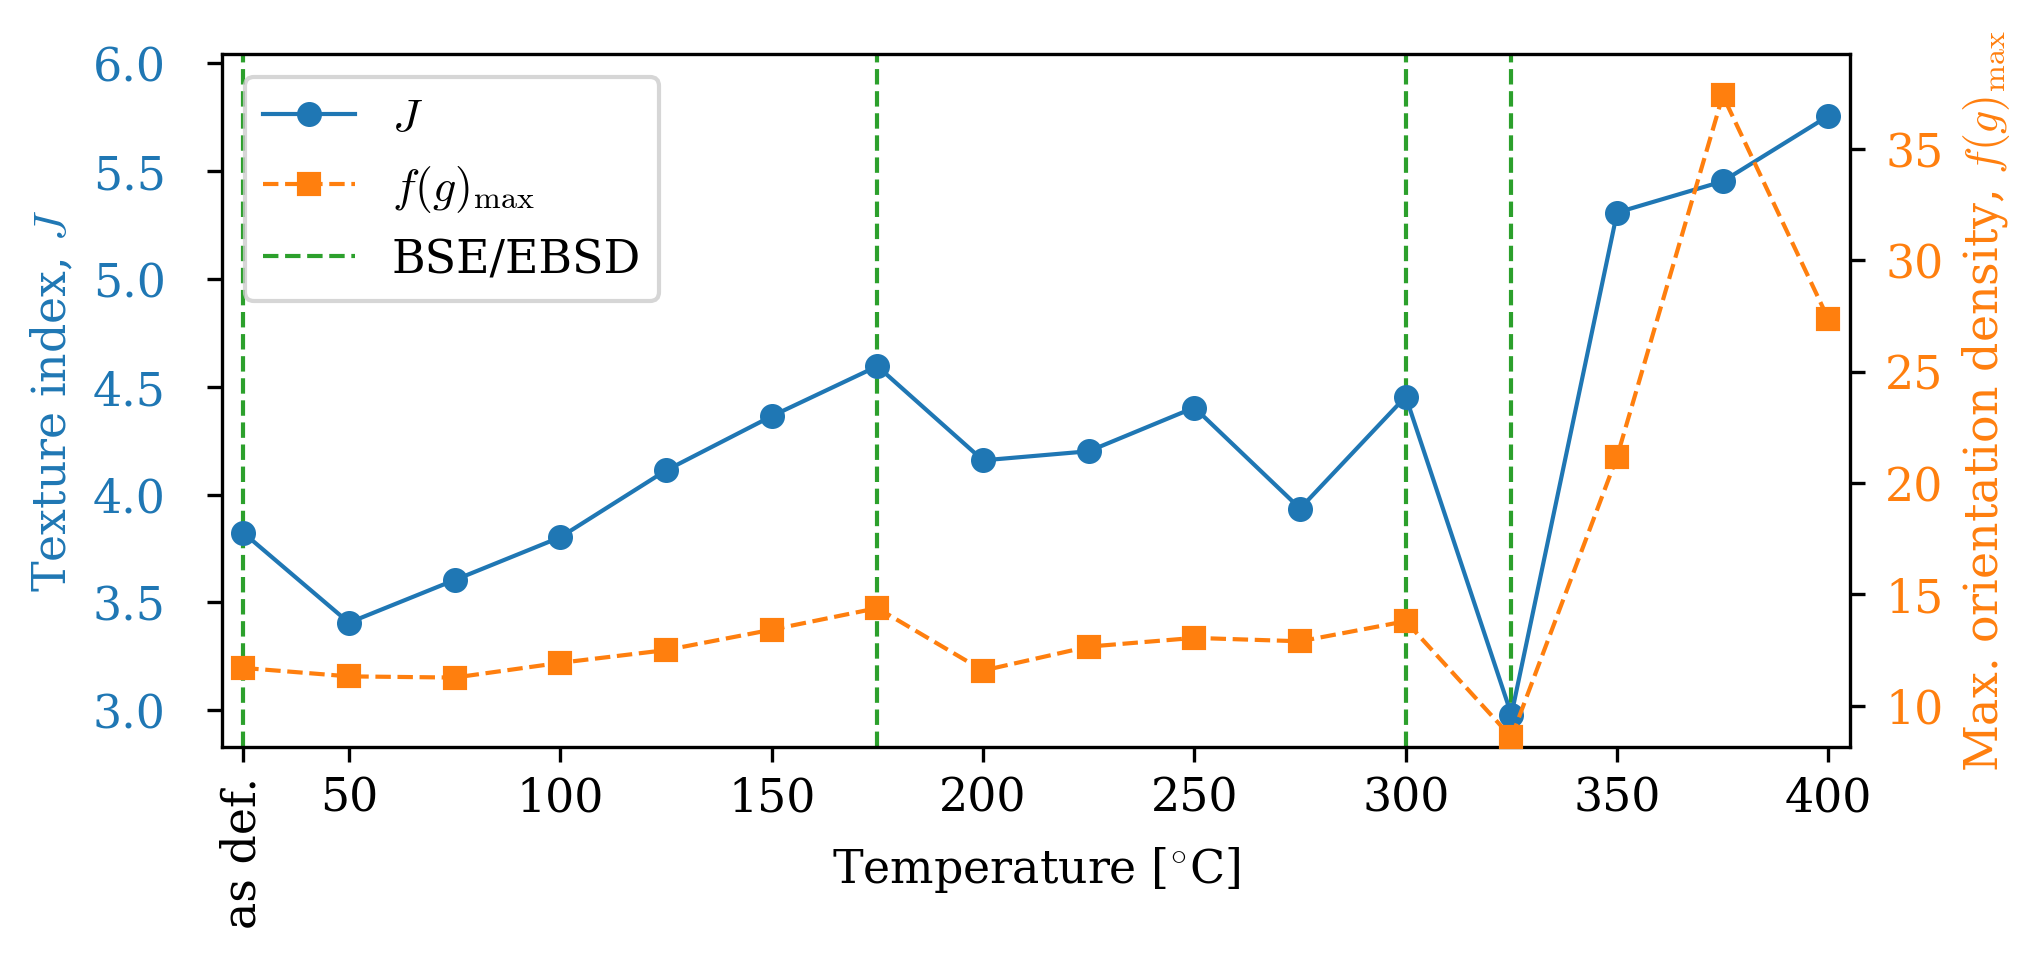

In [6]:
# Mask out None values
mask = np.isfinite(texture.textureindex.values.astype(np.double))

# Tick properties
xtick_loc = np.array([0, 1, 3, 5, 7, 9, 11, 13, 15])
xtick_labels = [
    "as def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90] + ["horizontal"] * (len(xtick_loc) - 2)

# Setup figure
fig, ax0 = plt.subplots(figsize=(7, 3))

# Plot texture index
idx_color = "C0"
p0, *_ = ax0.plot(
    texture.index[mask],
    texture.textureindex[mask],
    "-o",
    color=idx_color,
    clip_on=False,
    zorder=3
)
ax0.set_ylabel("Texture index, $J$", color=idx_color)
ax0.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)

# Plot ODF max
odfmax_color = "C1"
ax1 = ax0.twinx()
ax1.plot(
    texture.index[mask],
    texture.odfmax[mask],
    "--s",
    color=odfmax_color,
    clip_on=False
)
ax1.set_ylabel("Max. orientation density, $f(g)_{\mathrm{max}}$", color=odfmax_color)
p1, *_ = ax0.plot(np.nan, "--s", color=odfmax_color)
ax1.set_frame_on(False)

# Tick parameters
ax0.set_xlim([texture.index.start - 0.2, texture.index.stop - 0.8])
ax0.set_ylim([0.95 * texture.textureindex.min(), 1.05 * texture.textureindex.max()])
ax1.set_ylim([0.95 * texture.odfmax.min(), 1.05 * texture.odfmax.max()])
ax0.set_xticks(xtick_loc)
ax0.set_xticklabels(xtick_labels)
ax0.tick_params(axis="y", labelcolor=idx_color, pad=10)
ax1.tick_params(axis="y", labelcolor=odfmax_color, pad=5)
for label, tick, rot in zip(
    ax0.get_xmajorticklabels(),
    ax0.get_xaxis().get_major_ticks(),
    xtick_rotations,
):
    label.set_rotation(rot)
    label.set_horizontalalignment(align)

# Conditions studied in more detail
for condition in [0, 6, 11, 12]:
    p3 = ax0.axvline(condition, color="C2", linestyle="--", label="BSE/EBSD")

# Legend
ax0.legend(
    [p0, p1, p3],
    ["$J$", "$f(g)_{\mathrm{max}}$", "BSE/EBSD"],
    frameon=True,
);

fig.savefig(os.path.join(dir_article, "rx_kinetics/texture_strength.svg"), **savefig_kw)

## Statistics per sample studied with BSE/EBSD

### Particle statistics

From all BSE images, not just the regions of interest (ROIs) in the corrected EBSD maps

In [3]:
regions_kw = dict(
    dx=step_size["bse"] * 1e-3,
    dy=step_size["bse"] * 1e-3,
    scan_unit="um",
    background_label=0
)

Read data generated in `bse3_particle_detection.ipynb`, combining them into
one dataset per temperature, thus loosing spatial information

In [17]:
ecd_max = 0
particles = {}
total_area = np.zeros(4)

for i, sample in enumerate(identifier):
    particle_area = []
    for j in range(3):
        labels = np.load(os.path.join(
            dir_data, f"prover/{sample}/{j + 1}/partdet/bse_labels_filled_filtered.npy"
        ))

        regions = MapRegions(labels, **regions_kw)
        
        total_area[i] += np.prod(regions.map_shape) * regions.dx * regions.dy
        
        particle_area.append(regions.area)

    area = np.hstack(particle_area)
    particles_i = pd.DataFrame(data=area, columns=["area"])
    particles_i["radius"] = np.sqrt(particles_i.area / np.pi)
    particles_i["ecd"] = 0.816 * 2 * particles_i.radius
    
    ecd_max_i = particles_i.ecd.max()
    if ecd_max_i > ecd_max:
        ecd_max = ecd_max_i
    
    particles[sample] = particles_i

Cumulative distribution function of particle sizes and area weighted histogram
of particle sizes $d$

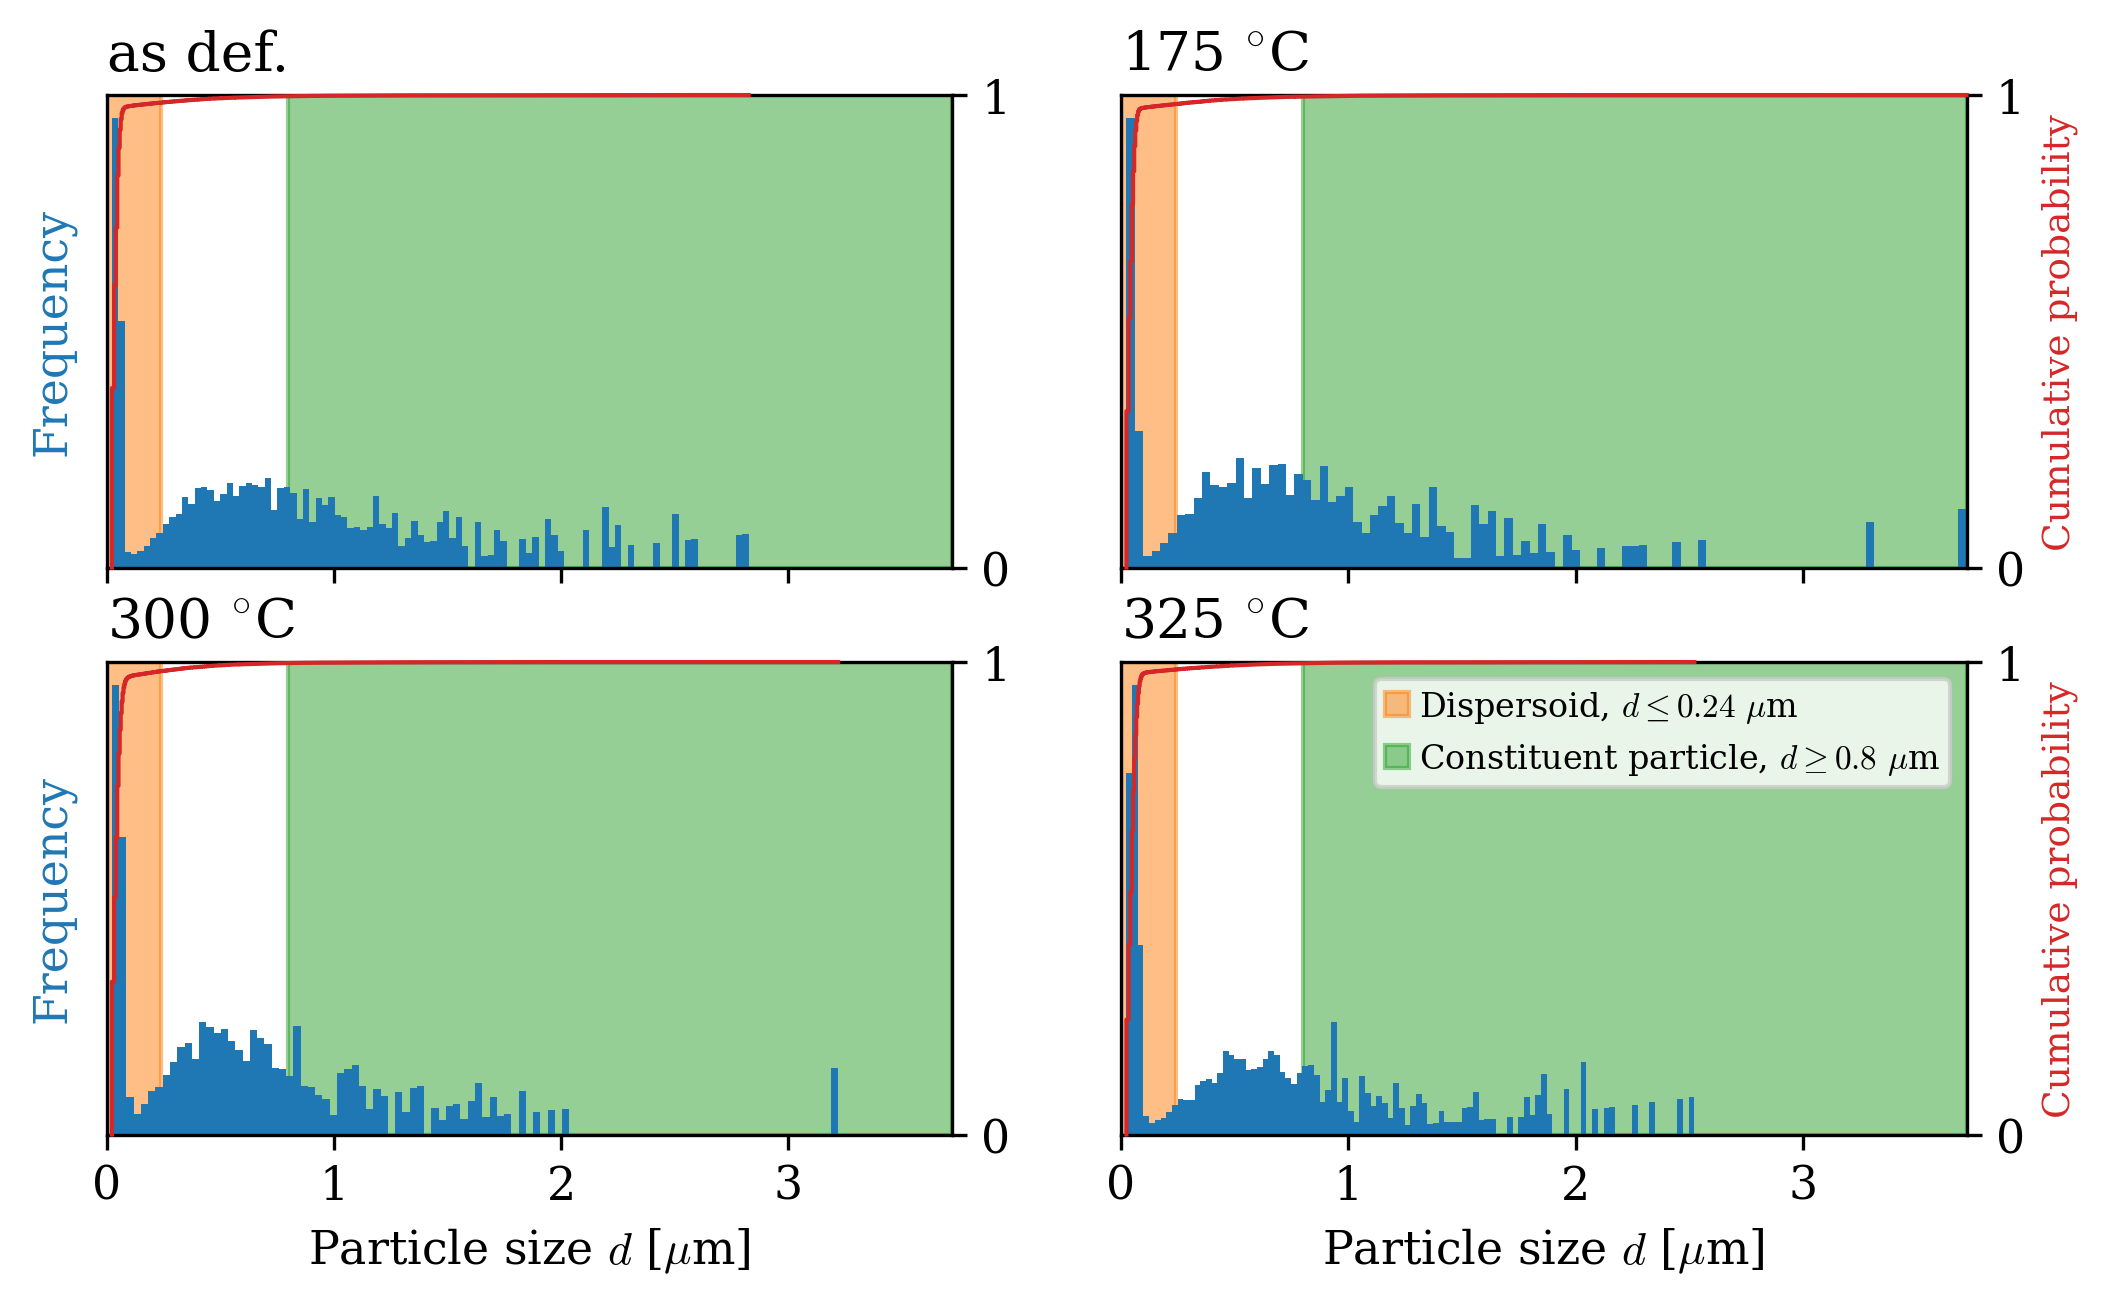

In [18]:
fig = plt.figure(figsize=(8, 4.5))

for i, sample in enumerate(particles.keys()):
    ecd = particles[sample].ecd
    ecd_sorted = np.sort(ecd)
    ecd_cdf = np.arange(particles[sample].shape[0]) / particles[sample].shape[0]
    
    host = host_subplot(2, 2, i + 1, figure=fig)
    par = host.twinx()
    *_, p1 = host.hist(ecd, bins=100, weights=particles[sample].area)
    p2, = par.plot(ecd_sorted, ecd_cdf, "C3", clip_on=False, zorder=5, linewidth=1)
    
    # Labels
    if i > 1:
        host.set_xlabel(r"Particle size $d$ [$\mu$m]")
    if i in [0, 2]:
        host.set_ylabel("Frequency")
        host.yaxis.get_label().set_color(p1[0].get_facecolor())
    if i in [1, 3]:
        par.set_ylabel("Cumulative probability", fontsize=plt.rcParams["font.size"] - 2)
        par.yaxis.get_label().set_color(p2.get_color())
    
    # Axes ticks and limits
    host.set_yticks([])
    host.set_xlim(0, ecd_max)
    par.set_ylim(0, 1)
    par.set_yticks([0, 1])
    if i < 2:
        host.set_xticklabels([])
    
    # Regions
    host.axvspan(
        xmin=0,
        xmax=dispersoid_threshold,
        color="C1",
        alpha=0.5,
        zorder=0,
        label=f"Dispersoid, $d \leq %.2f$ $\mu$m" % dispersoid_threshold,
    )
    host.axvspan(
        xmin=constituent_threshold,
        xmax=ecd_max,
        color="C2",
        alpha=0.5,
        zorder=0,
        label=f"Constituent particle, $d \geq %.1f$ $\mu$m" % constituent_threshold,
    )
    
    # Title
    host.set_title(titles[i], loc="left")
    
    # Legend
    if i == 3:
        host.legend(
            loc="upper right",
            handlelength=0.7,
            handletextpad=0.3,
            borderpad=0.3,
            fontsize=plt.rcParams["font.size"] - 3
        )

Other particle statistics:

Particle volume fraction $F_V$

$$
F_V = \frac{\sum_i^n A_i}{A_{\mathrm{total}}}.
$$

Number of particles per unit volume $N_V$

$$
N_V = \frac{3F_V}{4\pi r^3}.
$$

Number of particles crossing unit area $N_S$

$$
N_S = 2rN_v = \frac{3F_V}{2\pi r^2}.
$$

Distance to nearest neighboring particle assuming particles distributed in a grid $\lambda$

$$
\lambda = \frac{1}{\sqrt{N_S}},
$$

In [19]:
columns=[
    "total_area",
    "fv", "fv_c", "fv_d",
    "ecd_mean", "ecd_var", "ecd_confint",
    "ecd_mean_c", "ecd_var_c", "ecd_confint_c",
    "ecd_mean_d", "ecd_var_d", "ecd_confint_d",
    "nv_mean", "nv_std",
    "nv_mean_c", "nv_std_c",
    "nv_mean_d", "nv_std_d",
    "ns_mean", "ns_std",
    "ns_mean_c", "ns_std_c",
    "ns_mean_d", "ns_std_d",
    "nn_distance_grid", "nn_distance_grid_c", "nn_distance_grid_d",
]
particle_stats = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)
particle_stats["total_area"] = total_area

for sample in particles.keys():
    area_i = particles[sample].area
    ecd_i = particles[sample].ecd
    radius_i = particles[sample].radius
    
    # Boolean masks for all, constituent and dispersoid particles
    mask_all = np.ones(ecd_i.size, dtype=bool)
    mask_c = ecd_i >= constituent_threshold
    mask_d = ecd_i <= dispersoid_threshold
    
    for mask, suffix in zip([mask_all, mask_c, mask_d], ["", "_c", "_d"]):
        area_mask = area_i[mask]
        ecd_mask = ecd_i[mask]
        radius_mask = radius_i[mask]

        # Volume fraction
        fv = area_mask.sum() / particle_stats.loc[sample]["total_area"]
        particle_stats.loc[sample]["fv" + suffix] = fv
        # Area weighted particle size
        ecd_mean = np.average(ecd_mask, weights=area_mask)
        particle_stats.loc[sample]["ecd_mean" + suffix] = ecd_mean
        ecd_var = np.average((ecd_mask - ecd_mean) ** 2, weights=area_mask)
        particle_stats.loc[sample]["ecd_var" + suffix] = ecd_var
        particle_stats.loc[sample]["ecd_confint" + suffix] = 1.96 * np.sqrt(ecd_var) / np.sqrt(ecd_var.size)
        # Number of particles per unit volume
        nv = 3 * fv / (4 * np.pi * radius_mask ** 3)
        particle_stats.loc[sample]["nv_mean" + suffix] = nv.mean()
        particle_stats.loc[sample]["nv_std" + suffix] = nv.std()
        # Number of particles per unit area
        ns = 2 * radius_mask * nv
        particle_stats.loc[sample]["ns_mean" + suffix] = ns.mean()
        particle_stats.loc[sample]["ns_std" + suffix] = ns.std()
        # Particle distance (grid)
        particle_stats.loc[sample]["nn_distance_grid" + suffix] = 1 / np.sqrt(ns.mean())

Statistics for particles (all, constituent and dispersoids)

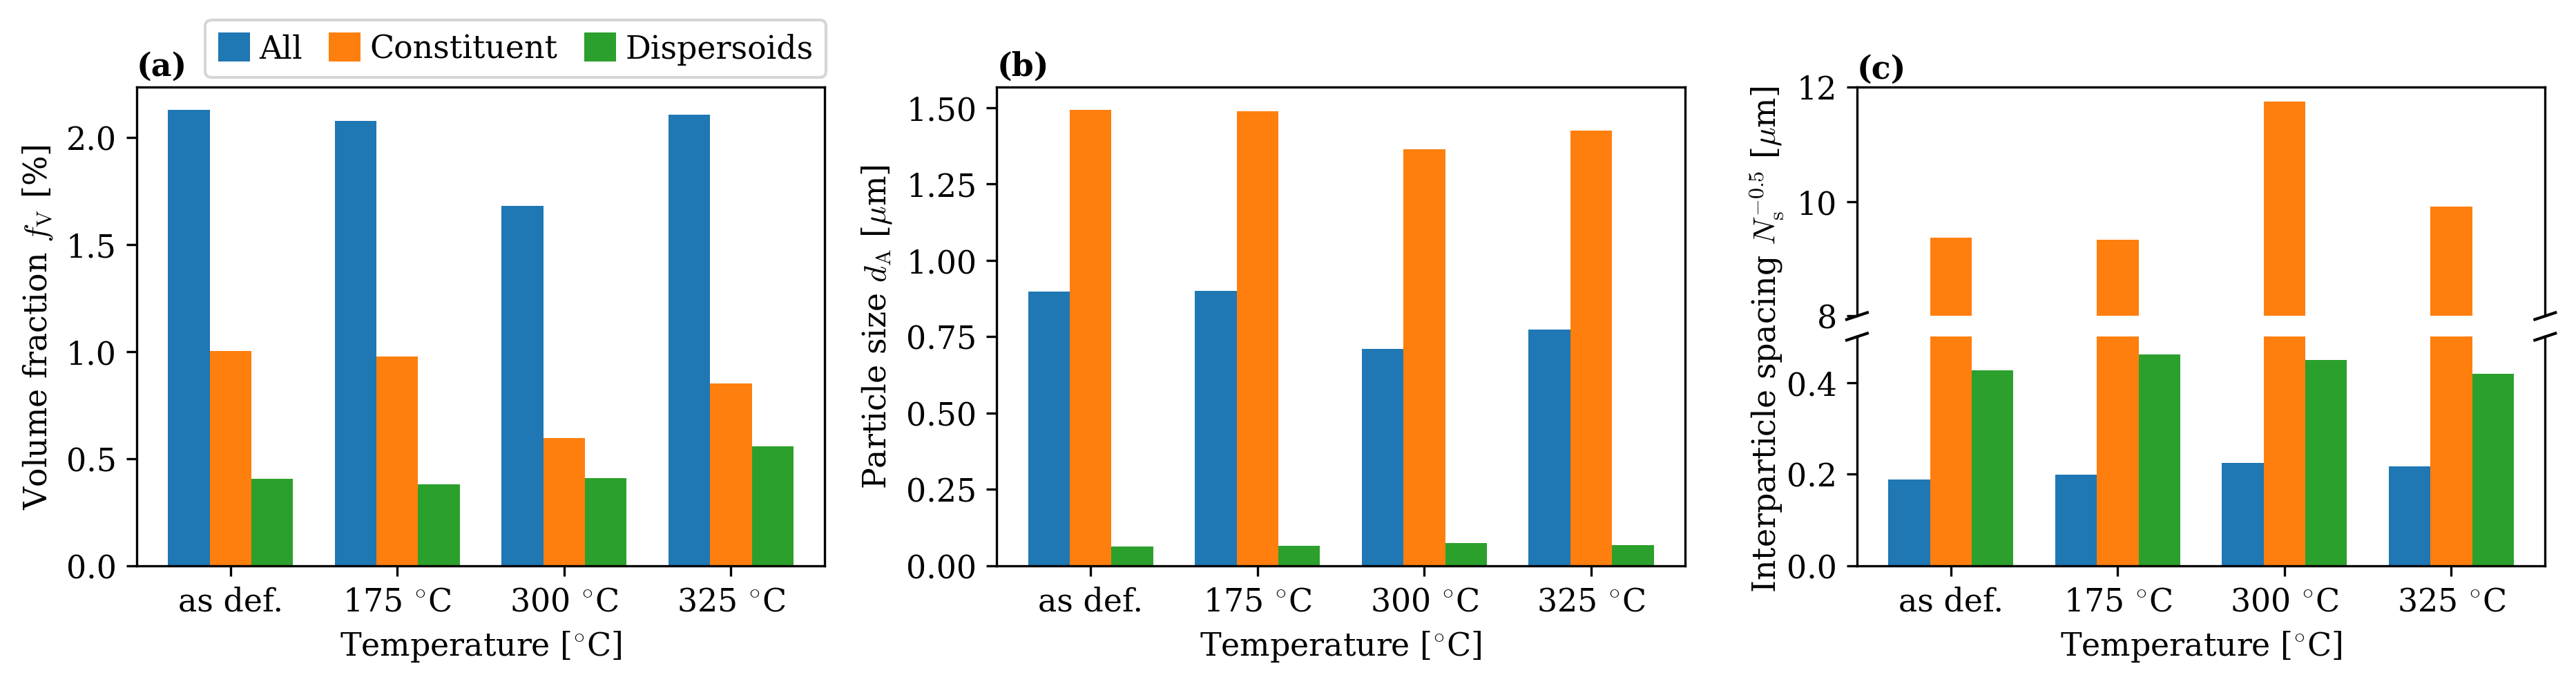

In [20]:
x = np.arange(len(particle_stats))
bar_width = 0.25

# Set up figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 3))

# (a) Volume fraction
# -------------------
ax0.bar(x - bar_width, 100 * particle_stats.fv, bar_width, label="All")
ax0.bar(x, 100 * particle_stats.fv_c, bar_width, label="Constituent")
ax0.bar(x + bar_width, 100 * particle_stats.fv_d, bar_width, label="Dispersoids")
ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_xlabel("Temperature [$^{\circ}$C]")
ax0.set_ylabel("Volume fraction $f_{\mathrm{V}}$ [%]")
ax0.text(0, 1.01, "(a)", transform=ax0.transAxes, **title_kw)

# (b) Average particle size
# -------------------------
ax1.bar(x - bar_width, particle_stats.ecd_mean, bar_width, label="All")
ax1.bar(x, particle_stats.ecd_mean_c, bar_width, label="Constituent")
ax1.bar(x + bar_width, particle_stats.ecd_mean_d, bar_width, label="Dispersoids")
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax1.set_ylabel("Particle size $d_{\mathrm{A}}$ [$\mathrm{\mu}$m]")
ax1.text(0, 1.01, "(b)", transform=ax1.transAxes, **title_kw)

# (c) Interparticle spacing
# -------------------------
ax2.bar(x - bar_width, particle_stats.nn_distance_grid, bar_width, label="All")
ax2.bar(x, particle_stats.nn_distance_grid_c, bar_width, label="Constituent")
ax2.bar(x + bar_width, particle_stats.nn_distance_grid_d, bar_width, label="Dispersoids", color="C2")
ax2.set_xticks(x)
ax2.set_xticklabels(titles)
ax2.set_xlabel("Temperature [$^{\circ}$C]")

divider = make_axes_locatable(ax2)
ax3 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax3)
ax3.bar(x - bar_width, particle_stats.nn_distance_grid, bar_width, label="All")
ax3.bar(x, particle_stats.nn_distance_grid_c, bar_width, label="Constituent")
ax3.bar(x + bar_width, particle_stats.nn_distance_grid_d, bar_width, label="Dispersoids", color="C2")
ax3.tick_params(bottom=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax2.set_ylim(0, 0.5)
ax3.set_ylim(8, 12)
d = 0.015
kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-d, d), (-d, d), **kwargs)
ax3.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax3.set_ylabel("Interparticle spacing $N_{\mathrm{s}}^{-0.5}$ [$\mathrm{\mu}$m]", y=-0.1)
ax2.text(0, 1.01, "(c)", transform=ax3.transAxes, **title_kw)

ax0.legend(
    bbox_to_anchor=(0.1, 1.02),
    bbox_transform=ax0.transAxes,
    loc="lower left",
    ncol=3,
    borderaxespad=0,
    handlelength=1,
    handleheight=1,
    handletextpad=0.3,
    columnspacing=0.83
)

fig.subplots_adjust(wspace=0.25)
fig.savefig(os.path.join(dir_article, "particle_stats/particle_stats.pdf"), **savefig_kw)

### Subgrain statistics

Read data generated with `MTEX`, combining them into one dataset per
temperature, thus loosing spatial information

In [74]:
grains = {}

for sample in identifier:
    n_grains = 0
    for j in range(3):
        # Read data from file
        grains_j = pd.read_csv(
            os.path.join(dir_data, f"prover/{sample}/{j + 1}/mtex/grains.txt"),
            delimiter=","
        )
        
        # Create new data frame or add to existing
        if j == 0:
            grains_i = grains_j
        else:
            grains_j["#id"] += n_grains
            grains_i = pd.concat((grains_i, grains_j))

        n_grains += grains_j.shape[0]

    # Relevant statistics
    grains_i["area"] = grains_i["size"] * 0.1 ** 2
    grains_i["radius"] = np.sqrt(grains_i.area / np.pi)
    grains_i["ecd"] = 0.816 * 2 * grains_i.radius
    grains_i["is_al"] = grains_i.phase == 1
    grains_i["is_rx"] = np.logical_and.reduce([
        grains_i["is_al"],
        grains_i["ecd"] > 1,
        grains_i["gos"] < np.deg2rad(2),
#        grains_i["xhab"] > 0.5,
    ])

    grains[sample] = grains_i

Various statistics per temperature per texture component

In [54]:
# Data frame columns
columns = ["total_area"]
other_columns = [
    "fv",
    "ecd_mean", "ecd_var", "ecd_confint",
    "gos_mean", "gos_var", "gos_confint",
    "gam_mean", "gam_var", "gam_confint",
]
for col in other_columns:
    for comp_name in comp_names_low:
        columns.append(col + "_" + comp_name)

# Empty data frame
grain_stats = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)

for sample in identifier:
    # Grains at this temperature
    grains_i = grains[sample]
    
    # Consider only subgrains
    grains_i = grains_i[~grains_i.is_rx]
    
    # Grain stats (unfilled) at this temperature
    grain_stats_i = grain_stats.loc[sample]

    # Total area of grains at this temperature
    grain_stats_i["total_area"] = grains_i.area.sum()
    
    # Component spresent, and how many there are of them, at this temperature
    ideal_unique_j, n_grains_j = np.unique(grains_i.ideal, return_counts=True)

    for comp_id in ideal_unique_j:
        # Grains of this component
        grains_j = grains_i[grains_i.ideal == comp_id]
        n_grains_j = len(grains_j)

        # Component name
        comp_name = comp_names_low[comp_id]

        # Volume fraction of component
        area_j = grains_j.area
        grain_stats_i["fv_" + comp_name] = area_j.sum() / grain_stats_i.total_area
        
        # ECD
        ecd_mean_j = np.average(grains_j.ecd, weights=area_j)
        ecd_var_j = np.average((grains_j.ecd - ecd_mean_j) ** 2, weights=area_j)
        grain_stats_i["ecd_mean_" + comp_name] = ecd_mean_j
        grain_stats_i["ecd_var_" + comp_name] = ecd_var_j
        grain_stats_i["ecd_confint_" + comp_name] = 1.96 * np.sqrt(ecd_var_j) / np.sqrt(n_grains_j)
        
        # GOS
        gos_mean_j = np.average(grains_j.gos, weights=area_j)
        gos_var_j = np.average((grains_j.gos - gos_mean_j) ** 2, weights=area_j)
        grain_stats_i["gos_mean_" + comp_name] = gos_mean_j
        grain_stats_i["gos_var_" + comp_name] = gos_var_j
        grain_stats_i["gos_confint_" + comp_name] = 1.96 * np.sqrt(gos_var_j) / np.sqrt(n_grains_j)
        
        # GAM
        gam_mean_j = np.average(grains_j.gam, weights=area_j)
        gam_var_j = np.average((grains_j.gam - gam_mean_j) ** 2, weights=area_j)
        grain_stats_i["gam_mean_" + comp_name] = gam_mean_j
        grain_stats_i["gam_var_" + comp_name] = gam_var_j
        grain_stats_i["gam_confint_" + comp_name] = 1.96 * np.sqrt(gam_var_j) / np.sqrt(n_grains_j)

Figure of volume fraction, number of grains and grain size per component per temperature

Text(0.5, 0, 'Temperature [$^{\\circ}$C]')

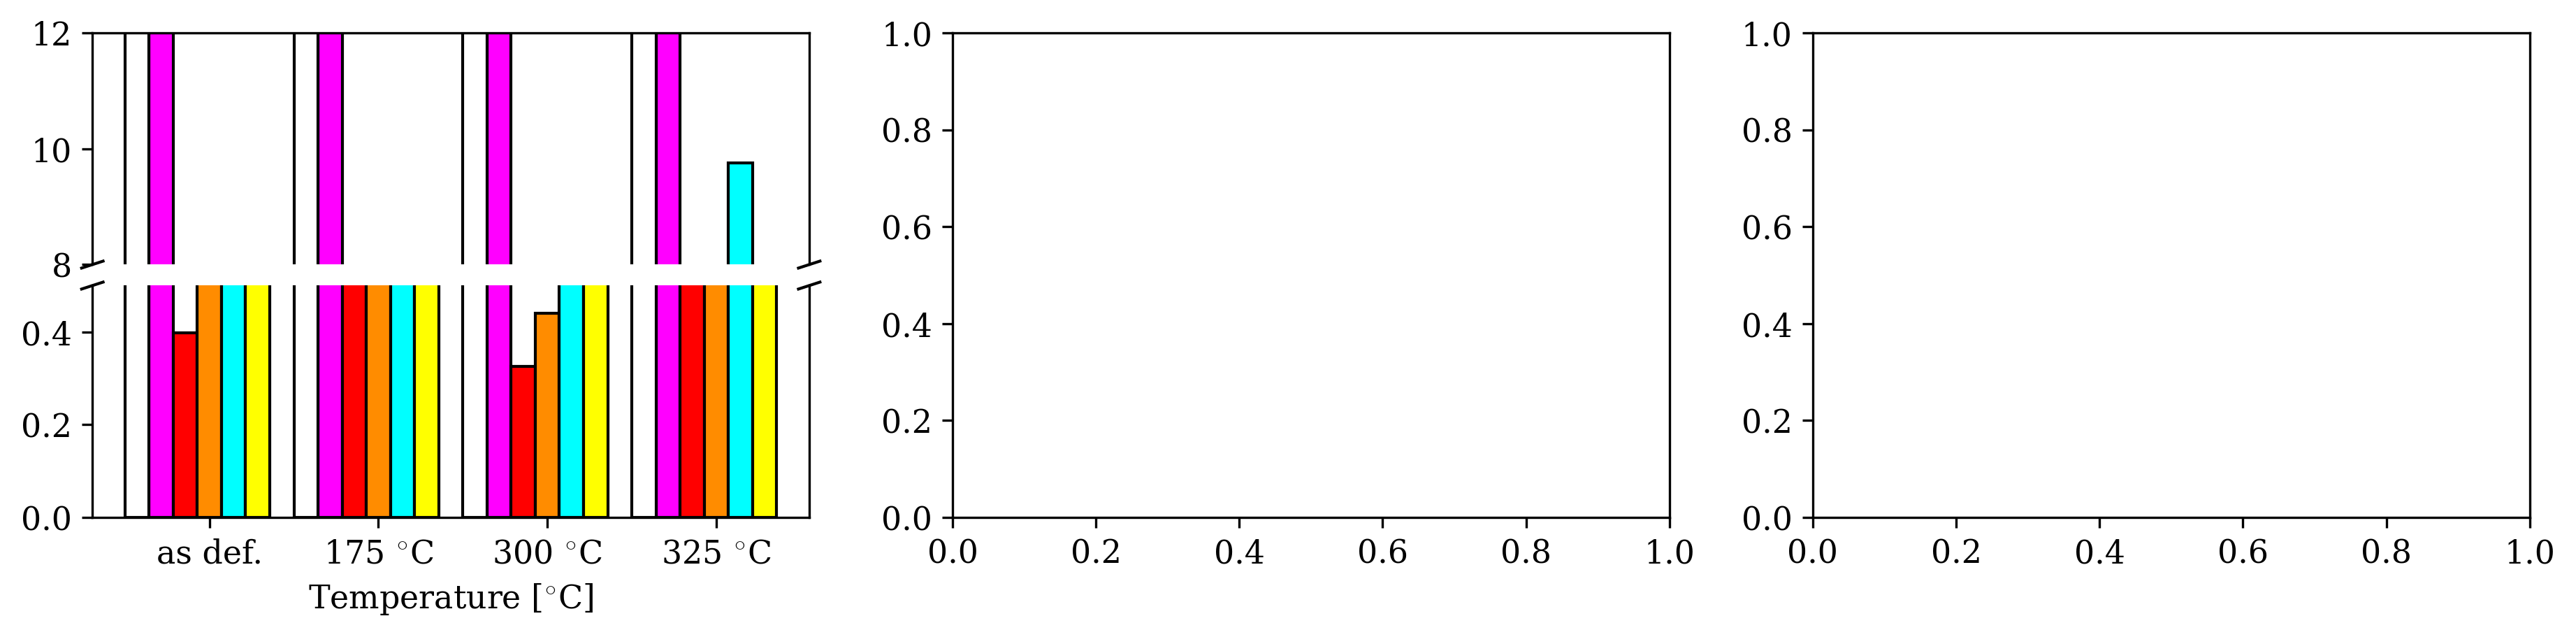

In [80]:
x = np.arange(len(grain_stats))
bar_width = 1 / 7

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 3))

# (a) Volume fraction
# -------------------
bar_kw = dict(width=bar_width, ec="k")
ax0.bar(
    x - (bar_width * 2),
    100 * (grain_stats.fv_br + grain_stats.fv_cu + grain_stats.fv_s),
    label=comp_name_def,
    color=comp_color_def,
    **bar_kw
)
divider = make_axes_locatable(ax0)
ax01 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax01)
ax01.bar(
    x - (bar_width * 2),
    100 * (grain_stats.fv_br + grain_stats.fv_cu + grain_stats.fv_s),
    label=comp_name_def,
    color=comp_color_def,
    **bar_kw
)
for w, name, c in zip(
    [-3 * bar_width, -1 * bar_width, -0 * bar_width, 1 * bar_width, 2 * bar_width],
    [comp_names[0],] + comp_names[4:],
    [comp_colors[0],] + comp_colors[4:]
):
    ax0.bar(x + w, 100 * grain_stats[f"fv_{name.lower()}"], label=name, color=c, **bar_kw)
    ax01.bar(x + w, 100 * grain_stats[f"fv_{name.lower()}"], label=name, color=c, **bar_kw)
ax01.tick_params(bottom=False, labelbottom=False)
ax0.spines["top"].set_visible(False)
ax01.spines["bottom"].set_visible(False)
ax0.set_ylim(0, 0.5)
ax01.set_ylim(8, 12)
d = 0.015
kwargs = dict(transform=ax01.transAxes, color='k', clip_on=False)
ax01.plot((-d, d), (-d, d), **kwargs)
ax01.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax0.transAxes)
ax0.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_xlabel("Temperature [$^{\circ}$C]");

NameError: name 'particle_stats' is not defined

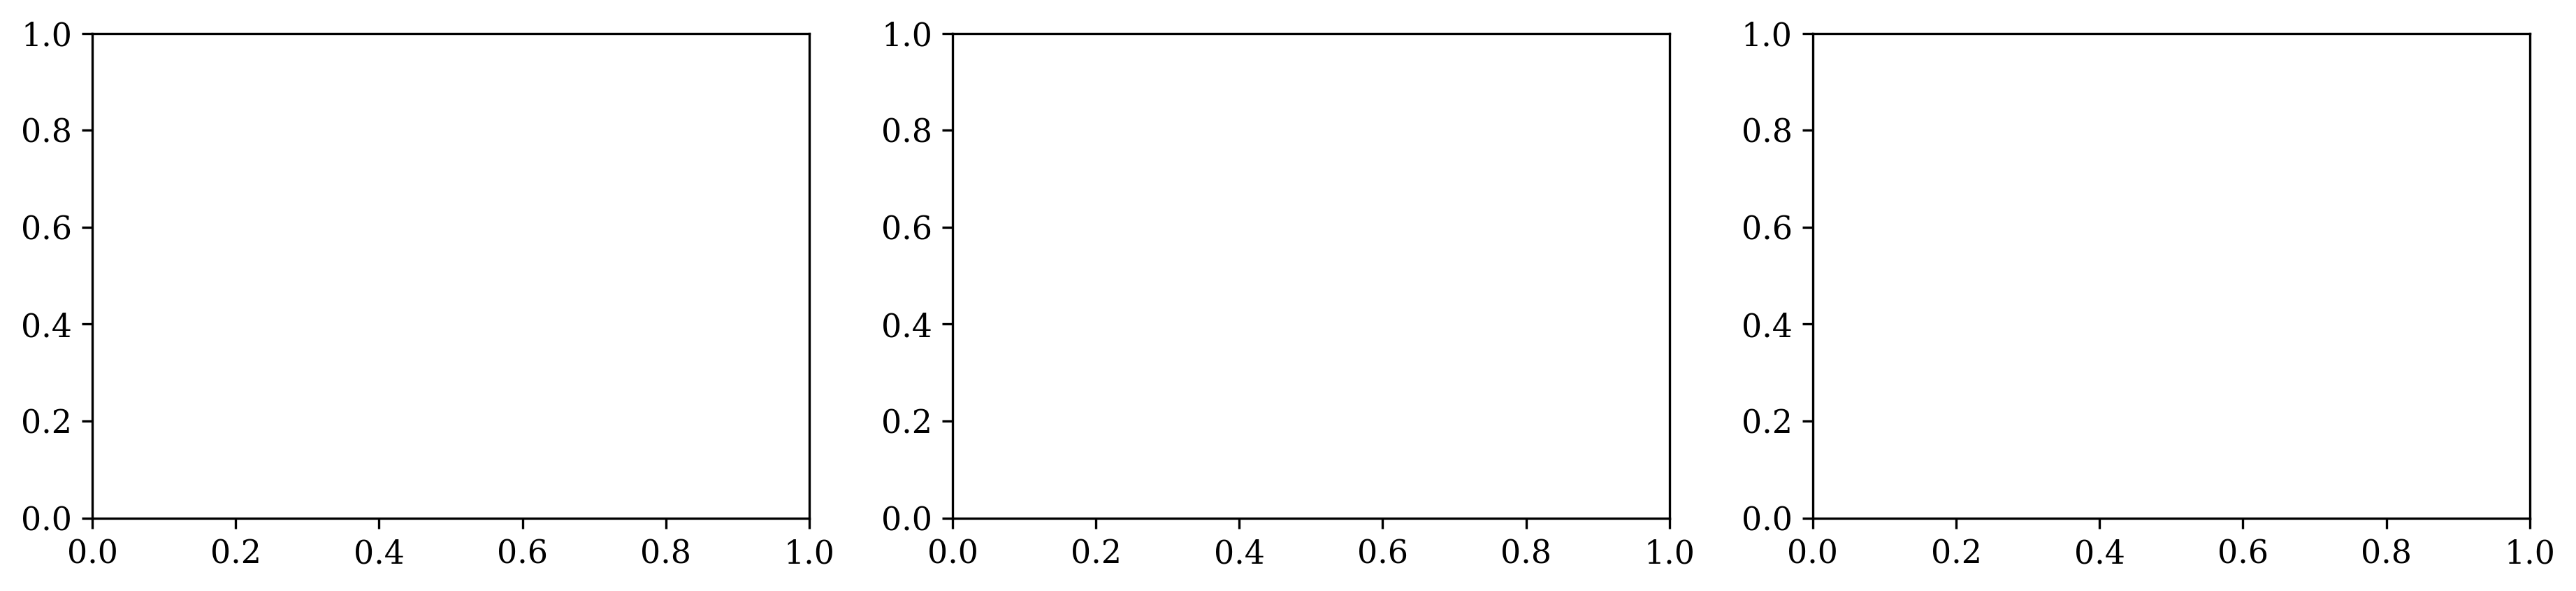

In [6]:
x = np.arange(len(grain_stats))
bar_width = 0.25

# Set up figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 3))

# (a) Volume fraction
# -------------------
ax0.bar(x - bar_width, 100 * particle_stats.fv, bar_width, label="All")
ax0.bar(x, 100 * particle_stats.fv_c, bar_width, label="Constituent")
ax0.bar(x + bar_width, 100 * particle_stats.fv_d, bar_width, label="Dispersoids")
ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_xlabel("Temperature [$^{\circ}$C]")
ax0.set_ylabel("Volume fraction $f_{\mathrm{V}}$ [%]")
ax0.text(0, 1.01, "(a)", transform=ax0.transAxes, **title_kw)

# (b) Average particle size
# -------------------------
ax1.bar(x - bar_width, particle_stats.ecd_mean, bar_width, label="All")
ax1.bar(x, particle_stats.ecd_mean_c, bar_width, label="Constituent")
ax1.bar(x + bar_width, particle_stats.ecd_mean_d, bar_width, label="Dispersoids")
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax1.set_ylabel("Particle size $d_{\mathrm{A}}$ [$\mathrm{\mu}$m]")
ax1.text(0, 1.01, "(b)", transform=ax1.transAxes, **title_kw)

# (c) Interparticle spacing
# -------------------------
ax2.bar(x - bar_width, particle_stats.nn_distance_grid, bar_width, label="All")
ax2.bar(x, particle_stats.nn_distance_grid_c, bar_width, label="Constituent")
ax2.bar(x + bar_width, particle_stats.nn_distance_grid_d, bar_width, label="Dispersoids", color="C2")
ax2.set_xticks(x)
ax2.set_xticklabels(titles)
ax2.set_xlabel("Temperature [$^{\circ}$C]")

divider = make_axes_locatable(ax2)
ax3 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax3)
ax3.bar(x - bar_width, particle_stats.nn_distance_grid, bar_width, label="All")
ax3.bar(x, particle_stats.nn_distance_grid_c, bar_width, label="Constituent")
ax3.bar(x + bar_width, particle_stats.nn_distance_grid_d, bar_width, label="Dispersoids", color="C2")
ax3.tick_params(bottom=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax2.set_ylim(0, 2)
ax3.set_ylim(8.5, 11)
d = 0.015
kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-d, d), (-d, d), **kwargs)
ax3.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax3.set_ylabel("Interparticle spacing $N_{\mathrm{s}}^{-0.5}$ [$\mathrm{\mu}$m]", y=-0.1)
ax2.text(0, 1.01, "(c)", transform=ax3.transAxes, **title_kw)

ax0.legend(
    bbox_to_anchor=(0.1, 1.02),
    bbox_transform=ax0.transAxes,
    loc="lower left",
    ncol=3,
    borderaxespad=0,
    handlelength=1,
    handleheight=1,
    handletextpad=0.3,
    columnspacing=0.83
)

fig.subplots_adjust(wspace=0.25)
fig.savefig(os.path.join(dir_article, "particle_stats/particle_stats.pdf"), **savefig_kw)